In [1]:
# Path
import sys
import os
qprc_path = os.path.abspath(os.path.join('..'))
if qprc_path not in sys.path:
    sys.path.append(qprc_path)

# Notebook description
In this notebook, we estimate the kernel Gram Matrix from Fuzzy data using the Non-singleton Kernel on Fuzzy sets.

The `kernels` module has the `gram_matrix_nonsingleton_gaussian_kernel`in charge of this estimation


## Kernel Gram Matrix estimation

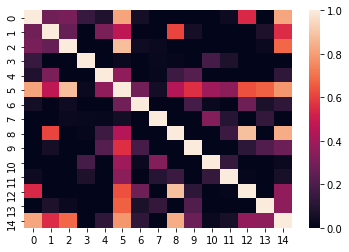

In [3]:
import numpy as np
from  kernelfuzzy.fuzzyset import FuzzySet
from  kernelfuzzy.memberships import gaussmf
from  kernelfuzzy.fuzzification import FuzzyData
from kernelfuzzy.kernels import nonsingleton_gaussian_kernel, gram_matrix_nonsingleton_gaussian_kernel
import seaborn as sns
from typing import Callable, List


fuzzy_dataset = FuzzyData.create_toy_fuzzy_dataset(num_rows=15, num_cols=3,parametric=True)

K = gram_matrix_nonsingleton_gaussian_kernel(fuzzy_dataset, fuzzy_dataset, KBF_param=1)
ax = sns.heatmap(K)

## Kernel Gram Matrix different bandwiths for the nonsingleton gaussian kernel on fuzzy sets


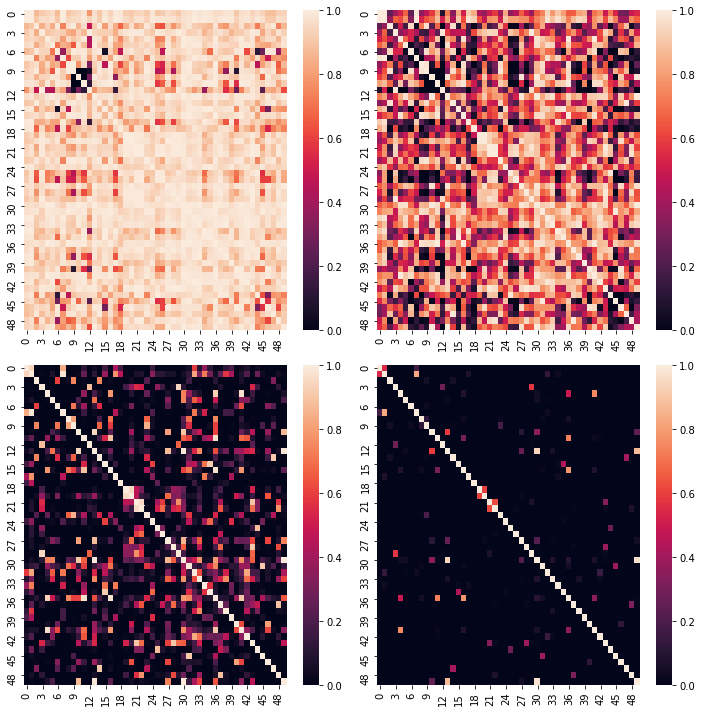

In [5]:
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt

# fuzzy dataset
fuzzy_dataset = FuzzyData.create_toy_fuzzy_dataset(num_rows=50, num_cols=2)

kernel_bandwidth=[0.05, 0.5, 5, 50]

# plotting
fig, axn = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axn.flat):
    K = gram_matrix_nonsingleton_gaussian_kernel(fuzzy_dataset, fuzzy_dataset, KBF_param=kernel_bandwidth[i])
    sns.heatmap(K, ax=ax)

fig.tight_layout()